### 问答系统(Question Answering)

In [1]:
# 加载SubjQA数据集

from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

> 可以看到：SubjQA数据集共有6大领域，分别为：
> - 图书
> - 电子产品
> - 零货
> - 电影
> - 餐饮
> - 旅游建议

In [2]:
# 在本次案例中使用电子这个领域
from datasets import load_dataset

subjqa = load_dataset("subjqa",name="electronics")

In [3]:
# question和answer键来取出分别的字符串集合
print(f"Question : {subjqa['train']['question'][1]}")
print(f"True Answer : {subjqa['train']['answers'][1]}")

Question : Is this music song have a goo bass?
True Answer : {'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
# 使用flatten()展开并详细的看看数据集
import pandas as pd

dfs = {split:dest.to_pandas() for split,dest in subjqa.flatten().items()}

for split,df in dfs.items():
    print(f"Number of questions in {split} : {df['id'].nunique()}")

Number of questions in train : 1295
Number of questions in test : 358
Number of questions in validation : 255


> SubjQA数据集中的常用列名：
> - title：亚马逊商品标准认证码
> - question：问题
> - answer.answer_text：注释者标记的评论中的文本跨度
> - answer.answer_start：回答的开始字符索引
> - context：上下文

In [5]:
# 简单采样一些数据
qa_cols = ['title','question','answers.text','answers.answer_start','context']

sample_df = dfs['train'][qa_cols].sample(2,random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


可以看到，数据集中存在了以下几个情况：
- 蹩脚的语法
- 空的`answers.text`或者`answers.answer_start`

In [6]:
# 使用开始索引和结束索引推断回答
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df['answers.text'].iloc[0][0])

sample_df['context'].iloc[0][start_idx:end_idx]

'this keyboard is compact'

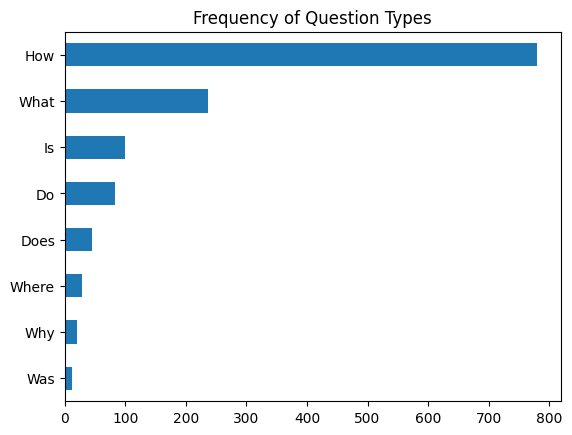

In [7]:
# 接下来，我们看看消费者更喜欢使用什么口吻来问问题
import matplotlib.pyplot as plt

counts = {}
question_types = ["What","How","Is","Does","Do","Was","Where","Why"]

for qt in question_types:
    counts[qt] = dfs['train']['question'].str.startswith(qt).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

### 从文本中提取答案
在本节中，我们需要理解如何：
- 表达进度学习问题
- 词元话并编码QA任务的文本
- 解决超出模型最大上下文大小的超长篇幅文本

#### 范围识别(Span Classification)
最常见的从文本中提取答案的方法是将问题是范围识别任务，其中开始和结束次元中词元将作为一个标签需要模型进行预测。
![SpanClassification](SpanClassification.png)

In [8]:
# 由于我们的数据集实在是太小了，拢共才1908条，因此我们需要一个已经通过超大语料训练好的QA模型
# 这里我们将使用deepset的minilm-uncased-squad2模型

from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/root/anaconda3/envs/transformer/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [9]:
# 使用模型进行简单的尝试
question = "How much music can this hold?"
context = "An MP3 is about 1MB/minute,so about 6000 hours depending on file size."

inputs = tokenizer(question,context,return_tensors="pt")

In [10]:
import pandas as pd
data = {}
for k in inputs.keys():
    data[k] = inputs[k].numpy()[0]
pd.DataFrame(data).T

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [11]:
# 使用解码函数来查看tokenizer是如何编码QA任务的输入的

tokenizer.decode(inputs['input_ids'][0])# 编码的格式为

'[CLS] how much music can this hold? [SEP] an mp3 is about 1mb / minute, so about 6000 hours depending on file size. [SEP]'

In [12]:
# 让模型处理编码后的输入
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
    
outputs

/root/anaconda3/envs/transformer/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/root/anaconda3/envs/transformer/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initia

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-1.1224, -4.7834, -5.3935, -5.2447, -5.2899, -5.4980, -4.9885, -6.1783,
         -1.1224,  0.3651, -0.0807, -1.5551,  3.9556,  4.9206, -2.7833, -3.7461,
         -1.7211, -4.6096, -1.3769,  4.0256,  4.9715, -0.2477, -3.0354, -4.8180,
         -2.2386, -3.4867, -3.5462, -1.1224]]), end_logits=tensor([[-1.0707, -5.4841, -5.0303, -5.1770, -5.4496, -5.5120, -5.2013, -4.6178,
         -1.0707, -3.7223, -0.7583, -3.6969, -2.9205, -1.7346,  0.3122, -2.8688,
          4.8807,  0.2692, -3.1317, -3.2404,  0.8239,  5.6645, -0.2568, -4.8910,
         -3.1677, -0.0130,  1.6739, -1.0707]]), hidden_states=None, attentions=None)

In [13]:
# 由于QA模型的目的是“去头去尾留中间”，所以我们需要先获取输出的开始和结束张量
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [14]:
# 输入、开始、结束张量应与编码的输入同长

print(f"Input IDs shape : {inputs.input_ids.size()}")
print(f"Start logits shape : {start_logits.size()}")
print(f"End logits shape : {end_logits.size()}")

Input IDs shape : torch.Size([1, 28])
Start logits shape : torch.Size([1, 28])
End logits shape : torch.Size([1, 28])


In [15]:
# 使用argmax并截取出最终的结果
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]

answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [16]:
# 使用pipeline流水线化QA过程
from transformers import pipeline

pipe = pipeline("question-answering",model=model,tokenizer=tokenizer)
pipe(question=question,context=context,topk=3) # 考虑到pipe默认会对分数进行排序，因此直接掏第一个就成

/root/anaconda3/envs/transformer/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2436027079820633, 'start': 36, 'end': 46, 'answer': '6000 hours'},
 {'score': 0.23150865733623505,
  'start': 16,
  'end': 46,
  'answer': '1MB/minute,so about 6000 hours'},
 {'score': 0.10571719706058502,
  'start': 16,
  'end': 26,
  'answer': '1MB/minute'}]

### 长篇幅处理


> 像其他的文本分类任务，例如情感判断(Sentiment)，你可以使用缩减长文本的办法来实现相同的模型训练效果，毕竟你的核心任务是将整个sequence进行编码后再交给模型，再使用softmax得到一个[1,num_classes]张量。但是这招在QA系统上是完全行不通的，这会产生欺骗行为在上下文的结尾，因此我们需要一个更合理的，不缩水的处理方法，即滑动窗口(*Sliding Window*)。  
通过不断将文本进行缩小，并添加空挡的方式，实现问题和捕获上下文的分离。

In [17]:
# 使用return_overflowing_tokens=True来使得模型能够使用动态滑窗
# 并且使用doc_stride_max_length来控制滑窗空挡的大小

example = dfs['train'].iloc[0][['question','context']]
tokenized_example = tokenizer(example['question'],example['context'],return_overflowing_tokens=True,max_length=100,stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [18]:
# 检查分窗的容量
for idx,window in enumerate(tokenized_example['input_ids']):
    print(f"Window #{idx} has {len(window)} tokens.")

Window #0 has 100 tokens.
Window #1 has 88 tokens.


In [19]:
# 最终来看看每个窗内的文本是什么样子的
for idx,window in enumerate(tokenized_example['input_ids']):
    print(f"Window #{idx} :\n {tokenizer.decode(window)}")

Window #0 :
 [CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]
Window #1 :
 [CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]


### 使用Haystack来构建QA管道

> 在我们前面的系统中，我们是将回答上下文和问题是作为一个整体输入到模型当中来，可现实是我们的QA系统应仅仅接受一个问题，而答案是需要模型自己来进行推断的。  
> 一种简单粗暴地方法就是直接把`一坨`回答杂糅到一起喂给模型，这么看似乎确实合理，但这会导致模型无法处理这样的超长文本，因此我们需要一个更好的方法来处理这个问题。  
> 为了解决这个问题，现代QA系统基本上基于`检索器-阅读器`的架构来实现，其中的几个重要组件如下：  
> - 检索器：检索的质量和反馈很大程度上取决于输入问题的质量。检索器通常分为两种：`稀疏`和`密集`。稀疏检索通常将词频作为一个稀疏矩阵来表述文档和问题。通过内积计算来得到问题和文档的相似度向量。另一方面，密集检索器通常使用像Transformer家族的编码器来生成一个上下文嵌入来表示问题和文档。这些嵌入编码了语义，以使得检索器可以通过理解搜索内容的方式来提升搜索精确度。  
> - 阅读器：阅读器的主要作用是提取从检索器提供的文档中获得目标答案，通常这类模型是一种阅读理解模型。
![QAPipeLine](NormallyQAPipeLine.png)

> Haystack是一个基于检索器-阅读器架构的QA系统，深度绑定HuggingFace Transformer库实现。  
> Haystack有两个重要的组成部件，分别为：
> - DocumentStore：面向文档数据库，用于存储文档和元数据以提供给检索器
> - PipeLine：将QA系统内组件进行整合，并允许自定义键值，从多个检索器实例中提取并聚合文档，等等...  
> 在开始之前，我们需要安装[ElasticSearch和HayStack](https://haystack.deepset.ai/tutorials/03_scalable_qa_system)  
  
> ※请务必安装zlib和libjpg※  
```bash
sudo apt-get install libjpeg-dev zlib1g-dev
```

In [20]:
# 启动ElasticSearch
import os
from subprocess import Popen,PIPE,STDOUT

es_server = Popen(args=["/root/elasticsearch-7.9.2/bin/elasticsearch"],stdout=PIPE,stderr=STDOUT,preexec_fn=lambda:os.setuid(1))

# 等待ElasticSearch启动
!sleep 30

In [21]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
import os

# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")
# 创建一个ElasticSearch的文档存储
document_store = ElasticsearchDocumentStore(host=host, username="", password="",return_embedding=True)

/root/anaconda3/envs/transformer/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/root/anaconda3/envs/transformer/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


> 默认情况下，`ElasticsearchDocumentStore`会生成两个指针，其中一个称之为`document`用于存储文档，而另一个称之为`label`用于存储已标记的回答空挡。  
> 现在我们只需要将SubjQA数据集填充给`ElasticsearchDocumentStore`即可。改类接受的元数据类型为`list[dictionary]`，且必须含有`text`和`meta`标签
```json
{
    "text":"<the-context>",
    "meta":{
        "filed_01":"<additional-metadata>",
        "filed_02":"<additional-metadata>"
    }
}
```

In [23]:
# 为document_store写入数据
for split,df in dfs.items():
    # 去除重复项目
    docs = [
        {
            "text":row['context'], # 在新版Haystack中，content字段是必须的，旧版的text字段已经被废弃
            "meta":{
                "item_id":row['title'],
                "question_id":row['id'],
                "split":split
            }
        }
        for _,row in df.drop_duplicates(subset=['context']).iterrows()
    ]
    document_store.write_documents(docs,index="document")

print(f"Loaded {document_store.get_document_count()} documents.")

Loaded 1615 documents.


### 初始化检索器
在本实验中，我们将使用一个基于稀疏矩阵和TF-IDF(余弦相似度)算法的检索器：`BM25Retriever`。  
BM25分数衡量搜索查询中有多少匹配文本，并通过快速饱和TF值和规范文档长度来改进TF-IDF，从而使短文档比长文档更受青睐。

In [24]:
# Import BM25Retriever
from haystack.retriever import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)

In [25]:
# Simple query test
item_id = "B0074BW614"
query = "Is it good for reading?"

retrieved_docs = retriever.retrieve(query=query,top_k=3,filters={"item_id":[item_id],"split":["train"]})

In [26]:
print(retrieved_docs[0].to_dict())

{'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}


### 初始化阅读器
在HayStack中，有两种常用的阅读器：
- FARMReader：基于deepset的FARM架构用于微调和部署transformer模型。与使用Hugging Face API训练的模型相兼容，可以直接加载或者从远程Hugging Face GIT存储库进行加载。
- TransformerReader：基于Hugging Face的transformer QA管道。仅适用于推理工作流。

尽管阅读器都以相同的方式来处理模型权重，但仍然有不同区别之处：
- 在HuggingFace Transformers中，QA管道将在每篇文章中使用`softmax`来标准化开始和结束预测值。这意味着只有在同一篇文章中提取的答案之间比较答案得分才有意义，其中置信度的总值为1。  
- 在`TransformerReader`类中有时会出现相同的预测，但是分数不同。这尤其会在长文本中发生如果答案需要依赖两个重叠窗口(*Overlapping Windows*)。好消息是：在FARM中这些重复结果将默认被移除。

In [27]:
# 加载MiniLM模型
from haystack.reader.farm import FARMReader # 在旧版API中使用from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length,doc_stride = 384,128
reader = FARMReader(model_name_or_path=model_ckpt,progress_bar=False,max_seq_len=max_seq_length,doc_stride=doc_stride,return_no_answer=True)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
# 简单使用reader进行测试
print(reader.predict_on_texts(
    question=question,
    texts=[context],
    top_k=1
))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.829151630401611, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5138806104660034, 'context': 'An MP3 is about 1MB/minute,so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 36, 'end': 46}], 'offsets_in_context': [{'start': 36, 'end': 46}], 'document_ids': ['bef233935fb49897d219b15700915833'], 'meta': {}}>]}


In [29]:
# 将两个组件合并为QA管道
from haystack.pipeline import ExtractiveQAPipeline

# 定义一个QA管道
pipe = ExtractiveQAPipeline(reader=reader,retriever=retriever)

In [30]:
# 让模型生成多个答案
n_answer = 3
preds = pipe.run(
    query=query,
    params={"Retriever":{"top_k":3},"Reader":{"top_k":n_answer},"filters":{"item_id":[item_id],"split":["train"]}},
)

In [31]:
print(f"Question: {preds['query']} \n")
for idx in range(n_answer):
    print(f"Answer {idx+1}: {preds['answers'][idx].to_dict()['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx].to_dict()['context']}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





> 提升QA系统性能的关键并不是提升你阅读器的性能，因为就算我们不断的调优阅读器的性能吗，但是一旦它第一时间无法找到相关联的文档，一切都是白扯。  
> 实际上，在QA管线中，真正会影响QA性能的上限的是：检索器的性能。

### 验证检索器的性能
一种常见的验证和评估检索器的方法称之为`回召(Recall)`，用于评估所有检索的关联文档的百分比。在本文中，“相关”仅简单的表述答案是否出现在文档中，所以给到一个问题集，我们可以通过统计一个答案出现在top_k文档中的次数进而计算其召回率

在HayStack中又两种普遍的方式来评估检索器的性能：
- 使用检索器内置的`eval()`函数。这样既可以用于开放和闭合域的QA系统，但不是所有的数据集都像SubjQA一样每个文档都一个与之配对简单的产品，并且我们需要使用产品ID来过滤每个`query`。
- 构建一个简单的管道来讲一个检索器和`EvalRetriever`类进行绑定。这允许自定义评分和query过滤。

### 密集文章检索(Dense Passage Retrieval)
如何在更小的*top_k*值下实现更高的召回率呢？类BM25检索器存在一种普遍的限制是：它不会捕捉到相关联的文档，这种情况会发生在当用户输入的问题存在包含了不匹配这些评论中存在的术语。  
一种可行的替换方式是使用密度嵌入(*Dense Embeddings*)来表示问题和文档，并且当前最流行的方法是使用`Dense Passage Retrieval(DPR)`，其核心思想是使用两个BERT模型作为问题和文章的编码器。  
具体工作流程如下图，编码器匹配输入文本并将其转换为一个*n维*的向量作为`[CLS]`词元。  
<img src="DPRWorkflow.png" width="500" height="700">